# The Python Global Interpreter Lock

It is surprising to many people new to Python that threads in Python do not actually execute bytecodes within those threads in parallel.  A mechanism called the Global Interpreter Lock (GIL)—which is a kind of lock, but in the C code that Python itself is written in—speeds up internals like reference counting, and makes developing extension modules easier.

In earlier lessons we showed function bytecode, and discussed the fact that switches between threads, at the Python level, are always passing control at some point *between* indivual bytecodes.  This means that threads in Python itself do not utilize multiple cores that your machine might have.

## A history lesson

Prior to about 2005, computers with multiple CPUs—let alone with multiple cores on the same silicon—were rare.  When Python, and a great many other languages, were created, at the operating-system-level itself, concurrency only created a simulation of parallelism via *time slicing*.  This is what Python does with language-level threads.

There are other Python implementations other than CPython.  Notably, neither Jython (for the JVM) or IronPython (for the .Net Common Language Runtime) have a GIL, and both have "true" threading.  That said, neither is generally faster that CPython, and neither is well maintained in recent years.  PyPy can be dramatically faster than CPython in many cases, but it retains the GIL.

## Does it matter?

Developers who first hear about Python's GIL, mostly those coming from other programming languages with a different model, tend to worry about the GIL making Python threading slow.  They are not *always* wrong, but mostly it makes little difference or can be worked around.

Overall, the answer is "maybe, but probably not."

* Python **itself** is not truly parallel, but all the capabilities Python provides for I/O run outside of Python itself.  If you read a file on disk, or data over the network, or from a socket, you leave the Python GIL, even with the functions built into Python.  If each thread is I/O bound, a small fraction of its work is spent on Python instructions themselves.

* Extension modules written in other languages, such as for numeric computing, also release the GIL.  If your long-running thread consists of calls to large NumPy, or PyTorch, or other library, functions, little of parallism is limited by the GIL. 

* When you really do need to write your computation in Python itself rather than extension libraries, you might consider `mutliprocessing`, discussed in the next lesson.  This has its own limitations, but it turns over concurrency/parallelism to the underlying operating system.

## Configuring time-slicing

CPython exposes quite a lot.  For example, you can query its context-switching goal, and modify it at runtime.

In [35]:
import sys
print(f"Threads (try to) switch every {sys.getswitchinterval()} seconds")

Threads (try to) switch every 0.005 seconds


In [36]:
# Increase the switching frequency slightly
sys.setswitchinterval(0.004)

## An I/O bound demonstration

Let's revisit the example from our first lesson and run an I/O bound task multithreaded to prove the GIL is not an issue in this case.

#### Sequential first

We'll check our crypto prices again. This time, each request is artificially delayed 3 seconds. We'll check only 3 prices, for the same date, so it's going to take approximately 6 seconds:

In [96]:
BASE_URL = "http://localhost:5000"

EXCHANGES = ['bitfinex', 'bitstamp', 'kraken']

start = time.time()

prices = [
    requests.get(f"{BASE_URL}/price/{exchange}/btc/2020-04-01").json()['close']
    for exchange in EXCHANGES
]

time.time() - start

def check_price(exchange, results):
    BASE_URL = "http://localhost:5000"
    return requests.get(f"{BASE_URL}/price/{exchange}/btc/2020-04-01").json()['close']

results = []

threads = [Thread(target=check_price, args=(exchange, results)) for exchange in EXCHANGES]

start = time.time()

[t.start() for t in threads];

[t.join() for t in threads];

time.time() - start

In [95]:
import time
import itertools
from queue import Queue
from threading import Thread

import requests

In [7]:
def mandelbrot(z0:complex, orbits:int) -> int:
    z = z0
    for n in range(orbits):
        if abs(z) > 2.0:
            return t
        z = z * z + z0
    return orbits

In [31]:
%%time
escape = 256
n = 1024
xc = .1015
yc = -.633
size = .01

canvas = np.empty(shape=(n, n))

for row, col in product(range(n), range(n)):
    x0 = xc - (size / 2) + (size * col / n)
    y0 = yc - (size / 2) + (size * row / n)
    z0 = complex(x0, y0)
    canvas[row, col] = mandelbrot(z0, escape)

CPU times: user 7.94 s, sys: 8.65 ms, total: 7.94 s
Wall time: 7.94 s


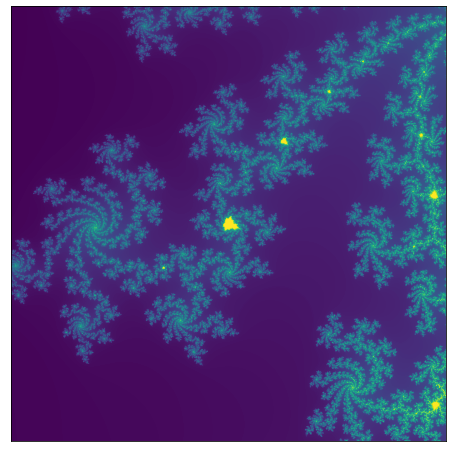

In [32]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.imshow(canvas);

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from itertools import product

## Searching primes

#### Understanding the problem, designing the solution

As great software engineers we are, we'll start first by understanding our problem. How much time does it take to find out if a number is prime or not?

In [81]:
start = time.time()

In [82]:
is_prime(numbers[0])

True

In [83]:
time.time() - start

0.5961849689483643

Approximately 0.5 seconds (we don't need to be very accurate, don't worry). If we have 10 prime numbers:

In [80]:
len(numbers)

10

we could expect a single threaded solution to take ~5 seconds. Let's start with that approach first:

#### Single threaded approach

A single threaded solution is the most basic one we can think of. No threads, locks, queues or concurrency. Plain old Python code to get the job done:

In [84]:
def search_primes_single_thread(numbers):
    return [n for n in numbers if is_prime(n)]

In [85]:
start = time.time()

In [86]:
results = search_primes_single_thread(numbers)

In [87]:
f"Time: {time.time() - start} seconds. Found {len(results)} primes out of {len(numbers)} total numbers."

'Time: 3.8426270484924316 seconds. Found 9 primes out of 10 total numbers.'

As we can see, it took less than 5 seconds, but it's within the same order of magnitude: between 1 and 10 seconds.

#### Speeding things up with multiple threads

We quickly realize that we could improve a lot the solution by using multiple threads. If I have 16 cores in this computer, each one of them can calculate a prime at the same time, and we'll be done a lot quicker. How quicker? Well, assuming I have 16 cores, and each core will definitively take 1 number to process, our solution should take no more than a second. The slowest prime to compute will be the total time.

Let's try it out!

In [88]:
def check_prime_worker(number, results):
    if is_prime(number):
        results.append(number)

(We should potentially use a thread safe collection, I know in CPython list append operations are thread safe)

In [89]:
results = []

In [90]:
threads = [Thread(target=check_prime_worker, args=(number, results)) for number in numbers]

In [91]:
start = time.time()

In [92]:
[t.start() for t in threads];

In [93]:
[t.join() for t in threads];

In [94]:
f"Time: {time.time() - start} seconds. Found {len(results)} primes out of {len(numbers)} total numbers."

'Time: 4.015429973602295 seconds. Found 9 primes out of 10 total numbers.'

**WHAT! 😦** 4 seconds! That's even slower than the sequential single-threaded solution. What is going on here? 🤔

Success! We've now corroborated that the GIL is actually released when waiting for I/O, which makes our programs "feel" like running in parallel.

## Summary

In this lesson we learned about one of the most "hated" features of Python: the GIL. Every post you read that is titled "why not Python?" or "Python vs \[insert language\]" will mention the GIL as a major drawback.

In our next lesson we'll learn how we can improve our code if it's CPU bound.